# animal shelter outcomes

#### in this competition our goal is to use several features from data collected on animals that arrived to a shelter
#### and predict the outcome (one of 5 possible outcomes) of that animal when left the shelter

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, log_loss

import random

random.seed(1234)

pd.options.display.max_columns = 100

#### first load the data set

In [2]:
tr_data = pd.read_csv('train.csv')
te_data = pd.read_csv('test.csv')
print ('train shape: {}'.format(tr_data.shape))
print ('test shape: {}'.format(te_data.shape))

train shape: (26729, 10)
test shape: (11456, 8)


##### now take a look at the data structure

In [3]:
tr_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
te_data.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### lets write down some insights about the data and especially about the diffrences between the train and test data:

1. the id structure is different
2. the OutcomeType & OutcomeSubtype are both missing 
   so although the target is only to predict the first one we can't use either of them in our model
3. we have a date feature that we can't use in our models - we'll have to deal with that too.
4. we have got data about pet's age - pay attention to the type of this feature and to Units Of Measure (onwards UOM)

## first lets get some intuition about the data

* plot class distributions
* plot classes by different features
* summarise unique values and explore value_counts

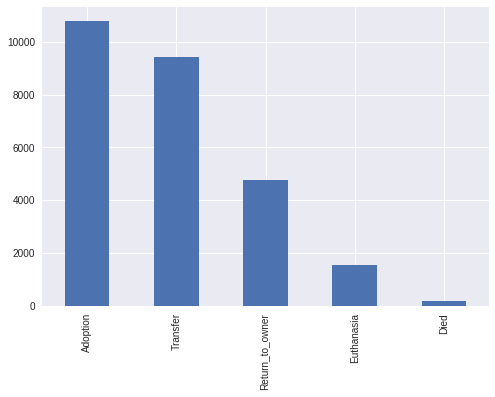

In [5]:
tr_data.OutcomeType.value_counts().plot(kind = 'bar')

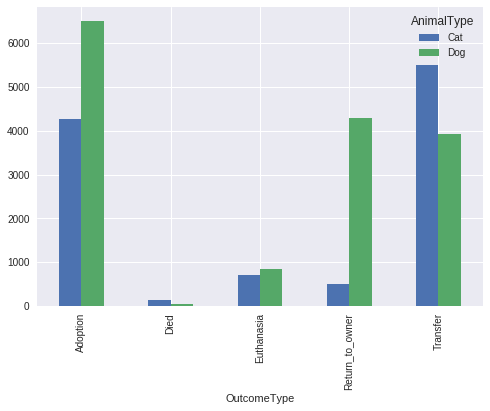

In [6]:
# let's try to split the aggragated classes by different features - well start with the animal type:
tr_data.pivot_table(columns='AnimalType',index = 'OutcomeType', values='DateTime', aggfunc=np.count_nonzero).plot(kind = 'bar')

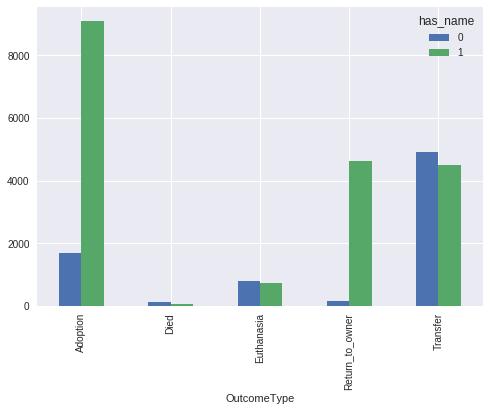

In [7]:
tr_data['has_name'] = 1-tr_data.Name.isnull()*1

tr_data.pivot_table(columns='has_name',index = 'OutcomeType', values='DateTime', aggfunc=np.count_nonzero).plot(kind = 'bar')
tr_data.drop(['has_name'],axis=1,inplace=True)

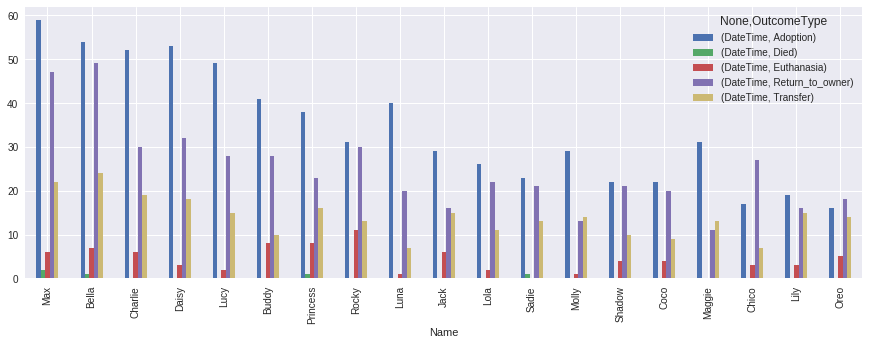

In [8]:
# so we learned that pets with names are more likely to be returned to their owner (makes sense)
# and also more likely to be adopted (sympathy?)
# lets try to dig a bit dipper to this feature

# let's create a pivot table that presents the counts of each name for each category 
names_pivot = tr_data.pivot_table(index=['Name'],columns=['OutcomeType'],values=['DateTime'], 
                    aggfunc=np.count_nonzero,fill_value=0, margins = True)

# now let's sort our pivot table so that the most common names will show first
names_pivot = names_pivot.sort_values(ascending = False,by=('DateTime','All'))

# lets view the first 20 , don't forget to set the plot area (using the figsize parameter)
names_pivot.iloc[1:20,:-1].plot(kind = 'bar',figsize=(15,5))

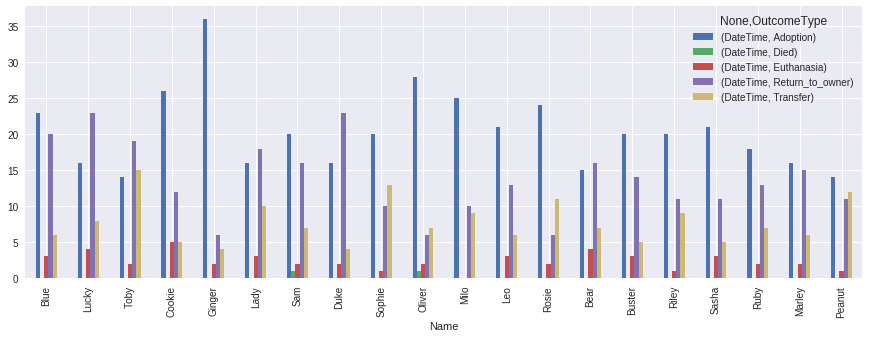

In [9]:
names_pivot.iloc[20:40,:-1].plot(kind = 'bar',figsize=(15,5))

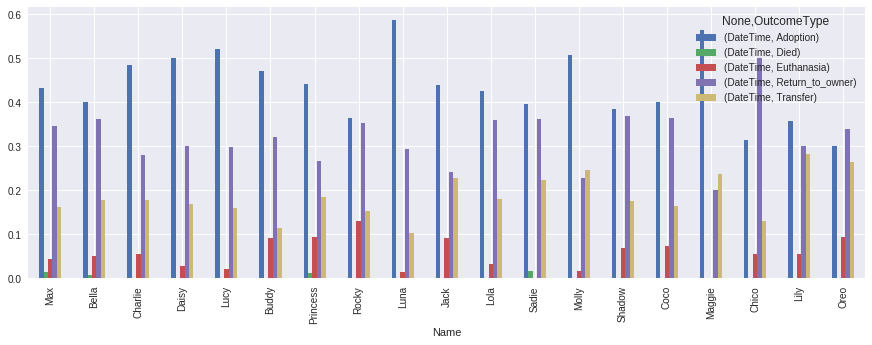

In [10]:
# as one of the students comented in the previous lesson, 
# sometimes its better to explore frequencies rather than explore the counts themselves

def piv2pcnt(pivoted):
    # this is a helper function to convert a pivot table of counted shows to frequencies
    # assumptions: the input is a pivot table with margins = true & the last column contains the sum of counts
    return pivoted.div(pivoted.iloc[:,-1],axis = 0)

piv2pcnt(names_pivot).iloc[1:20,:-1].plot(kind = 'bar',figsize=(15,5))

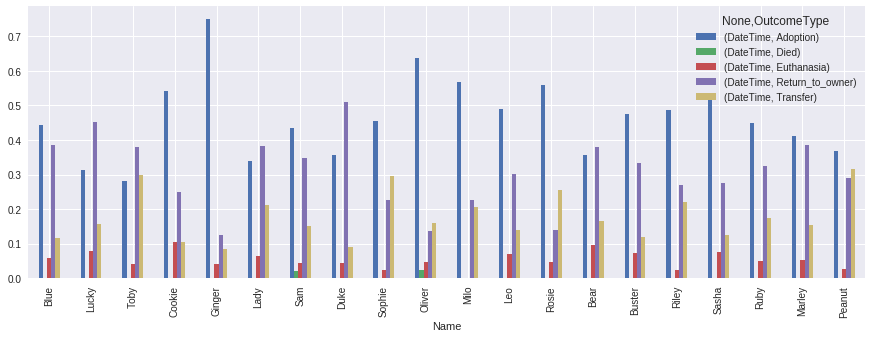

In [11]:
# now do the same for the next 20:
piv2pcnt(names_pivot).iloc[20:40,:-1].plot(kind = 'bar',figsize=(15,5))

#### you are welcome to try and explore some more interesting ratios from the train data

let me know about your findings!

## data pre-processing 

This is where the fun starts :-)
#### "our model is only as good as the features that we supply it with"
* pre-process dates - extract numerical feautres such as time of day, month, weekday etc. 
* pre-process names and other character features (remove sparse names, remove capitalization, correct spelling)

In [12]:
# a good practice is to apply all transformations on the concatination of train and test data
# so we'll first set appart the target and other features in which we can't use for the modeling stage
# and then concatinate the train and test data

In [13]:
target = tr_data.OutcomeType
train_ids,test_ids = tr_data.AnimalID , te_data.ID
tr_data.drop(['OutcomeType','OutcomeSubtype','AnimalID'],axis=1,inplace=True)
te_data.drop(['ID'],axis=1,inplace=True)
full_data = pd.concat([tr_data,te_data],axis=0)

In [14]:
def extract_date_features(date_column):
    temp = pd.to_datetime(date_column)
    return pd.DataFrame({"year": temp.dt.year,
                         "month": temp.dt.month,
                         "dayofyear": temp.dt.dayofyear,
                         "weekofyear": temp.dt.weekofyear,
                         "dayofweek": temp.dt.dayofweek,
                         "hour": temp.dt.hour
                        })

In [15]:
full_data = pd.concat([full_data,extract_date_features(full_data['DateTime'])],axis=1)
full_data.drop(['DateTime'],axis=1,inplace=True)

# now let's look at the new features we created
full_data.iloc[:,-5:].head()

,dayofyear,hour,month,weekofyear,year
0,43,18,2,7,2014
1,286,12,10,41,2013
2,31,12,1,5,2015
3,192,19,7,28,2014
4,319,12,11,46,2013


## what could be wrong with the age feature?
* its textual rather than numerical, but thats not all...
* UOM are different

In [16]:
full_data.AgeuponOutcome.value_counts()[:10]

1 year      5737
2 years     5383
2 months    4929
3 years     2589
3 months    1788
1 month     1782
4 years     1506
5 years     1406
4 months    1283
3 weeks      950
Name: AgeuponOutcome, dtype: int64

In [17]:
# before parsing the text (especially when using the apply function) 
# we need to verify that all the text feature has values to prevent an error while running
full_data.AgeuponOutcome.fillna('1 unknown',inplace=True)

#now we can split the data to quantity and type of time specified
temp = pd.DataFrame([(float(x.split(' ')[0]),x.split(' ')[1]) for x in full_data.AgeuponOutcome])
temp.columns = ['quan','timetype']

In [18]:
#now lets explore the unique values that the type of time feature contains
temp['timetype'].unique()

array(['year', 'years', 'weeks', 'month', 'months', 'days', 'week', 'day',
       'unknown'], dtype=object)

In [19]:
# since we want to generalize let's convert single form to plural
temp['timetype'].replace(['year','month','week', 'day' ],[ 'years', 'months', 'weeks',  'days'],inplace = True)

In [20]:
# now we can convert the feature values to run on a single scale  
def unify_age_scale(row):
    timetype = row.timetype
    quan = row.quan
    if timetype=='years':
        return quan*365
    elif timetype=='weeks':
        return quan*7
    elif timetype=='days':
        return quan
    elif timetype=='unknown':
        return -999
    else:
        return quan*30
    
temp = temp.apply(unify_age_scale,axis = 1)

full_data['rescaled_AgeuponOutcome'] = temp
full_data.drop(['AgeuponOutcome'],axis=1,inplace=True)
del temp

In [21]:
# we can now convert some more of the textual features with less varience to numeric representation:
full_data.AnimalType = full_data.AnimalType.replace(['Dog','Cat'],[0,1])

In [22]:
full_data.SexuponOutcome.fillna(value='unknown unknown',inplace=True)
full_data.SexuponOutcome.replace(['Unknown'],['unknown unknown'],inplace=True)

In [23]:
temp = pd.DataFrame([x.split(' ') for x in full_data.SexuponOutcome])
temp.columns = ['status','sex']
print ('the unique values fot status are: {}'.format(temp.status.unique()))
print ('the unique values fot sex are: {}'.format(temp.sex.unique()))

the unique values fot status are: ['Neutered' 'Spayed' 'Intact' 'unknown']
the unique values fot sex are: ['Male' 'Female' 'unknown']


In [24]:
# let's replace these values to numeric as well:
# * it's a good practice to use extreme value for unknown we'll usually be using -999 or -9999
temp.status.replace(['Neutered', 'Spayed', 'Intact', 'unknown'],[0,1,2,-999],inplace=True)
temp.sex.replace(['Male', 'Female', 'unknown'],[0,1,-999],inplace=True)

In [25]:
full_data['sex'] = temp.sex
full_data['status'] = temp.status
full_data.drop(['SexuponOutcome'],axis=1,inplace=True)

In [26]:
full_data.Breed.value_counts()[:20]

Domestic Shorthair Mix       12587
Pit Bull Mix                  2776
Chihuahua Shorthair Mix       2498
Labrador Retriever Mix        1949
Domestic Medium Hair Mix      1217
German Shepherd Mix            830
Domestic Longhair Mix          753
Siamese Mix                    562
Australian Cattle Dog Mix      513
Dachshund Mix                  437
Miniature Poodle Mix           336
Boxer Mix                      330
Border Collie Mix              324
Australian Shepherd Mix        256
Rat Terrier Mix                226
Catahoula Mix                  216
Yorkshire Terrier Mix          213
Miniature Schnauzer Mix        203
Jack Russell Terrier Mix       203
Domestic Shorthair             194
Name: Breed, dtype: int64

In [27]:
# only needed if not already installed 
#pip install wordcloud 
## '!' mark within a notebook cell runs a shell command within the cell

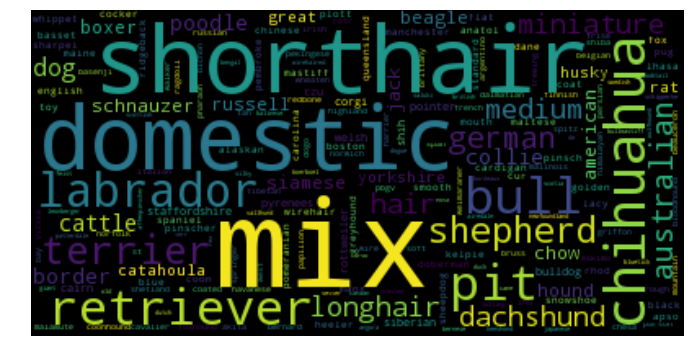

In [28]:
from wordcloud import WordCloud
text = full_data.Breed.str.cat(sep = ' ')
wc = WordCloud(collocations=False).generate(text.lower())
plt.figure(figsize=(15,6))
#plt.subplot2grid(2,1)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [29]:
#list(wc.words_.keys())
#pd.DataFrame({'words':list(wc.words_.keys()),'frequency':list(wc.words_.items())})
frequency_df = pd.DataFrame(list(wc.words_.items()))
frequency_df.columns = ['word','frequency']
frequency_df.sort_values('frequency',ascending=False)[:10]

,word,frequency
0,mix,1.000000
1,shorthair,0.511123
2,domestic,0.466788
3,chihuahua,0.115779
4,retriever,0.111041
5,bull,0.110728
6,pit,0.108500
7,labrador,0.102915
8,terrier,0.076402
9,shepherd,0.062784


##### check for common symilarities rather than exact same - this helps to prevent overfitting
lets create some features from what we can see in the word cloud:

* has "mix"
* has "shorthair"
* has "domestic"
* has "chihuahua"
* has "retriever"
* etc.


* notice we used x.lower() function that we learned about in our last lecture to unify the different spelling with same meaning

In [30]:
num_breed_features = 300
for i,w in enumerate(frequency_df.word[:num_breed_features]):
    full_data['has_{}_inBreed'.format(w)] = full_data.Breed.apply(lambda x: (w in x.lower())*1)

# once we extracted all of the features we can remove the breed original feature
full_data.drop(['Breed'],axis=1,inplace=True)

In [31]:
# now try to do the same with the color feature
text = full_data.Color.str.cat(sep = ' ')
wc = WordCloud(collocations=False).generate(text.lower())
num_color_features = 300
for i,w in enumerate(frequency_df.word[:num_color_features]):
    full_data['has_{}_inColor'.format(w)] = full_data.Color.apply(lambda x: (w in x.lower())*1)

# once we extracted all of the features we can remove the breed original feature
full_data.drop(['Color'],axis=1,inplace=True)

In [32]:
full_data.head(8)

,Name,AnimalType,dayofweek,dayofyear,hour,month,weekofyear,year,rescaled_AgeuponOutcome,sex,status,has_mix_inBreed,has_shorthair_inBreed,has_domestic_inBreed,has_chihuahua_inBreed,has_retriever_inBreed,has_bull_inBreed,has_pit_inBreed,has_labrador_inBreed,has_terrier_inBreed,has_shepherd_inBreed,has_australian_inBreed,has_german_inBreed,has_hair_inBreed,has_medium_inBreed,has_longhair_inBreed,has_miniature_inBreed,has_dachshund_inBreed,has_dog_inBreed,has_cattle_inBreed,has_poodle_inBreed,has_border_inBreed,has_collie_inBreed,has_siamese_inBreed,has_boxer_inBreed,has_american_inBreed,has_hound_inBreed,has_beagle_inBreed,has_russell_inBreed,has_schnauzer_inBreed,has_chow_inBreed,has_jack_inBreed,has_yorkshire_inBreed,has_rat_inBreed,has_catahoula_inBreed,has_great_inBreed,has_husky_inBreed,has_staffordshire_inBreed,has_pointer_inBreed,has_bulldog_inBreed,...,has_chesa_inColor,has_bay_inColor,has_retr_inColor,has_bloodhound_inColor,has_finnish_inColor,has_spitz_inColor,has_beauceron_inColor,has_mountain_inColor,has_schipperke_inColor,has_newfoundland_inColor,has_dutch_inColor,has_bullmastiff_inColor,has_angora_inColor,has_de_inColor,has_airedale_inColor,has_scottish_inColor,has_setter_inColor,has_terr_inColor,has_swedish_inColor,has_vallhund_inColor,has_japanese_inColor,has_dogue_inColor,has_bordeaux_inColor,has_bernese_inColor,has_silky_inColor,has_leonberger_inColor,has_wirehaired_inColor,has_cane_inColor,has_corso_inColor,has_bluetick_inColor,has_affenpinscher_inColor,has_feist_inColor,has_balinese_inColor,has_keeshond_inColor,has_patterdale_inColor,has_crested_inColor,has_nova_inColor,has_scotia_inColor,has_duck_inColor,has_tolling_inColor,has_rex_inColor,has_boerboel_inColor,has_bengal_inColor,has_wolfhound_inColor,has_canaan_inColor,has_bobtail_inColor,has_saluki_inColor,has_old_inColor,has_giant_inColor,has_british_inColor
0,Hambone,0,2,43,18,2,7,2014,365.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Emily,1,6,286,12,10,41,2013,365.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pearce,0,5,31,12,1,5,2015,730.0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,1,4,192,19,7,28,2014,21.0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,0,4,319,12,11,46,2013,730.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Elsa,0,4,115,13,4,17,2014,30.0,1,2,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Jimmy,1,5,87,13,3,13,2015,21.0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,NaN,1,3,120,17,4,18,2015,21.0,-999,-999,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
full_data['has_name'] = full_data.Name.isnull()*1
dummied_names = pd.get_dummies(full_data.Name)


In [34]:
# add dummies for 200 most common names
for n in names_pivot.iloc[1:1001].index:
    full_data['name_{}'.format(n)] = full_data.Name.apply(lambda x: (n in str(x).lower())*1)
#and finally remove the original name feature
full_data.drop(['Name'],axis=1,inplace=True)

In [35]:
# once we're done with preprocessing we can separate the train and test again
tr_processed_data = full_data[:26729]
te_processed_data = full_data[26729:]
te_processed_data.head()

,AnimalType,dayofweek,dayofyear,hour,month,weekofyear,year,rescaled_AgeuponOutcome,sex,status,has_mix_inBreed,has_shorthair_inBreed,has_domestic_inBreed,has_chihuahua_inBreed,has_retriever_inBreed,has_bull_inBreed,has_pit_inBreed,has_labrador_inBreed,has_terrier_inBreed,has_shepherd_inBreed,has_australian_inBreed,has_german_inBreed,has_hair_inBreed,has_medium_inBreed,has_longhair_inBreed,has_miniature_inBreed,has_dachshund_inBreed,has_dog_inBreed,has_cattle_inBreed,has_poodle_inBreed,has_border_inBreed,has_collie_inBreed,has_siamese_inBreed,has_boxer_inBreed,has_american_inBreed,has_hound_inBreed,has_beagle_inBreed,has_russell_inBreed,has_schnauzer_inBreed,has_chow_inBreed,has_jack_inBreed,has_yorkshire_inBreed,has_rat_inBreed,has_catahoula_inBreed,has_great_inBreed,has_husky_inBreed,has_staffordshire_inBreed,has_pointer_inBreed,has_bulldog_inBreed,has_siberian_inBreed,...,name_Lightning,name_Black,name_Simone,name_Izy,name_Birdie,name_Jordy,name_Tyler,name_Agatha,name_Poncho,name_Big Red,name_Rita,name_Albert,name_Hardy,name_Sid,name_Bianca,name_Unique,name_Uno,name_Harmony,name_Ivan,name_Indigo,name_Milton,name_London,name_Deuce,name_Mica,name_Presley,name_Denver,name_Brandi,name_Apple,name_John,name_Kaiser,name_Guero,name_Poochie,name_Prancer,name_Bosley,name_Bosco,name_Willy,name_Odie,name_Truffle,name_Lori,name_Truman,name_Homer,name_Yoshi,name_Piglet,name_Petra,name_Tula,name_Jersey,name_Zip,name_Valentino,name_Josephine,name_Emerald
0,0,0,285,12,10,42,2015,365.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,5,207,17,7,30,2014,365.0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,13,12,1,2,2016,730.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,5,362,18,12,52,2013,21.0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,267,17,9,39,2015,730.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
target.replace(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'],[0,1,2,3,4],inplace=True)

In [37]:
from sklearn.model_selection import GridSearchCV
# gbc = GradientBoostingClassifier()
# gbc
# %%time
# gbc = GradientBoostingClassifier(max_depth=6,n_estimators=100,subsample=0.6,random_state=1234)
# X_train,X_val,y_train,y_val = train_test_split(tr_processed_data,target,test_size=0.3, random_state=1234)#,stratify=True)
# gbc.fit(X_train,y_train)
# pred = gbc.predict(X_val)
# print(classification_report(y_pred=pred,y_true=y_val))
# pred_proba = gbc.predict_proba(X_val)
# print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

In [38]:
%%time
from xgboost import XGBClassifier
gbc = XGBClassifier(objective='multi:softprob',
                    learning_rate=0.2,
                    subsample=0.7,
                    colsample_bytree=0.9,
                    colsample_bylevel=0.7,
                    max_depth=5,
                    nthread=4,
                    n_estimators=30,
                    seed=1234)

X_train,X_val,y_train,y_val = train_test_split(tr_processed_data,target,test_size=0.3, random_state=1234)
gbc.fit(X_train,y_train)
pred = gbc.predict(X_val)
print(classification_report(y_pred=pred,y_true=y_val))
pred_proba = gbc.predict_proba(X_val)
print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

/home/nati/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


             precision    recall  f1-score   support

          0       0.70      0.85      0.77      3216
          1       1.00      0.08      0.15        51
          2       0.62      0.17      0.27       507
          3       0.51      0.49      0.50      1439
          4       0.76      0.70      0.73      2806

avg / total       0.68      0.68      0.67      8019

log_loss: 0.7813733931705643
CPU times: user 2min 18s, sys: 7.3 s, total: 2min 25s
Wall time: 39.8 s


In [39]:
pred_test = gbc.predict_proba(te_processed_data)
sub = pd.DataFrame(pred_test)
sub.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
te_data = pd.read_csv('test.csv')
sub.reset_index(te_data.ID)
sub['ID'] = te_data.ID
sub.to_csv('submission_XGB_train_test_split.csv',index=False) 


## validation reliability

In [40]:
%%time
import xgboost as xgb
params = {'objective':'multi:softprob',
                    'learning_rate':0.2,
                    'subsample':0.8,
                    'colsample_bytree':0.9,
                    'colsample_bylevel':0.7,
                    'max_depth':7,
                    'nthread':4,
                    'eval_metric':'mlogloss',
                    'n_estimators':100,
                    'num_class':5,
                    'seed':1234}
bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(tr_processed_data,label=target),verbose_eval=2,
                nfold=5,early_stopping_rounds=20,num_boost_round=30)

[0]	train-mlogloss:1.43348+0.00112441	test-mlogloss:1.43938+0.00181952
[2]	train-mlogloss:1.17765+0.00516358	test-mlogloss:1.19243+0.00696368
[4]	train-mlogloss:1.02632+0.0051674	test-mlogloss:1.0488+0.00760239
[6]	train-mlogloss:0.928728+0.00574437	test-mlogloss:0.9585+0.00782342
[8]	train-mlogloss:0.86086+0.00394076	test-mlogloss:0.897263+0.00929057
[10]	train-mlogloss:0.814273+0.00343648	test-mlogloss:0.85766+0.0103765
[12]	train-mlogloss:0.779795+0.0032172	test-mlogloss:0.829722+0.0112289
[14]	train-mlogloss:0.752312+0.00293883	test-mlogloss:0.809001+0.0115756
[16]	train-mlogloss:0.730946+0.00294371	test-mlogloss:0.793902+0.01194
[18]	train-mlogloss:0.713863+0.00280929	test-mlogloss:0.783013+0.0122745
[20]	train-mlogloss:0.699131+0.00288513	test-mlogloss:0.774338+0.0125908
[22]	train-mlogloss:0.687066+0.00230516	test-mlogloss:0.76811+0.0130274
[24]	train-mlogloss:0.676696+0.00250679	test-mlogloss:0.763041+0.0133887
[26]	train-mlogloss:0.667969+0.00248686	test-mlogloss:0.759215+0.01

In [41]:
bst = xgb.train(params=params,dtrain=xgb.DMatrix(tr_processed_data,label=target),
                num_boost_round=30)
test_pred = bst.predict(xgb.DMatrix(te_processed_data))

In [43]:
sub = pd.DataFrame(test_pred)
sub.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
te_data = pd.read_csv('test.csv')
sub['ID'] = te_data.ID
sub.to_csv('xgb_all_features.csv',index=False)

In [47]:
from sklearn.feature_selection import RFECV
gbc = XGBClassifier(objective='multi:softprob',
                    learning_rate=0.2,
                    subsample=0.7,
                    colsample_bytree=1,
                    colsample_bylevel=1,
                    max_depth=5,
                    nthread=4,
                    n_estimators=10,
                    seed=1234)
rfecv = RFECV(estimator=gbc, step=0.05, cv=5, scoring='neg_log_loss')
rfecv.fit(tr_processed_data, target)
print("Optimal number of features : %d" % rfecv.n_features_)
print('rfecv rankings:')
print(rfecv.ranking_)

Optimal number of features : 221


## hyper-parameter optimization

In [ ]:
%%time

#this example of iterative grid search is based on Darius Barušauskas methodology and experience

tune_grid = {'max_depth':[2,4,6,8,10,12,14]}

score = 'neg_log_loss'
print("Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(XGBClassifier(objective='multi:softprob',
                                learning_rate=0.2,
                                subsample=0.7,
                                colsample_bytree=1,
                                colsample_bylevel=1,
                                max_depth=5,
                                nthread=4,
                                n_estimators=100,
                                seed=1234), 
                   tune_grid, cv=5, scoring='%s' % score,n_jobs=4)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
%%time
# continue with Darius Barušauskas steps
tune_grid = {'reg_alpha':[2,4,16,64]}

print("Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(XGBClassifier(objective='multi:softprob',
                                learning_rate=0.2,
                                subsample=0.7,
                                colsample_bytree=1,
                                colsample_bylevel=1,
                                max_depth=6,
                                nthread=4,
                                n_estimators=100,
                                seed=1234), 
                   tune_grid, cv=5, scoring='%s' % score,n_jobs=4)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
%%time
# continue with Darius Barušauskas steps
tune_grid = {'reg_lambda':[2,4,8,16]}

print("Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(XGBClassifier(objective='multi:softprob',
                                learning_rate=0.2,
                                subsample=0.7,
                                colsample_bytree=1,
                                colsample_bylevel=1,
                                max_depth=6,
                                nthread=4,
                                n_estimators=100,
                                seed=1234), 
                   tune_grid, cv=5, scoring='%s' % score,n_jobs=4)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
print(pd.DataFrame(clf.cv_results_).loc[:,['params','mean_train_score','std_train_score',
                                     'mean_test_score','std_test_score']])

In [ ]:
print(pd.DataFrame(clf.cv_results_).loc[:,['params','mean_train_score','std_train_score',
                                     'mean_test_score','std_test_score']])

In [ ]:
%%time
# continue with Darius Barušauskas steps
tune_grid = {'min_child_weight':[1,0,5,10,20,50]}

print("Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(XGBClassifier(objective='multi:softprob',
                                learning_rate=0.2,
                                subsample=0.7,
                                colsample_bytree=1,
                                colsample_bylevel=1,
                                max_depth=5,
                                nthread=4,
                                n_estimators=100,
                                reg_lambda = 8,
                                reg_alpha = 2,
                                seed=1234), 
                   tune_grid, cv=5, scoring='%s' % score,n_jobs=-1)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
print(pd.DataFrame(clf.cv_results_).loc[:,['params','mean_train_score','std_train_score',
                                     'mean_test_score','std_test_score']])

In [ ]:
%%time
# continue with Darius Barušauskas steps
tune_grid = {'colsample_bytree':[0.3,0.5,0.7,0.9],
             'subsample':[0.3,0.5,0.7,0.9]}

print("Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(XGBClassifier(objective='multi:softprob',
                                learning_rate=0.2,
                                subsample=0.7,
                                colsample_bytree=1,
                                colsample_bylevel=1,
                                max_depth=5,
                                nthread=4,
                                n_estimators=100,
                                reg_lambda = 2,
                                reg_alpha = 2,
                                min_child_weight=5,
                                seed=1234), 
                   tune_grid, cv=5, scoring='%s' % score,n_jobs=4)

clf.fit(X_train, y_train)

print(pd.DataFrame(clf.cv_results_).loc[:,['params','mean_train_score','std_train_score',
                                     'mean_test_score','std_test_score']])

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=4)
tune_grid = {'leaf_size':[30],'n_neighbors':[250,500,1000],'p':[0.8,1.1]}
score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(KNeighborsClassifier(n_jobs=4), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=4)
tune_grid = {'leaf_size':[30],'n_neighbors':[250,500,1000],'p':[1.01,1.1]}
score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(KNeighborsClassifier(n_jobs=4), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
# I guess nearest neighbours isn't a great pick for this data...
# lets try hyperopt:
# its a good practice to set all parameters and only tune one at first to make sure everything works smothly
# prior to the long run of the true search space we're after

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def hyperopt_train_test(params):
    X_ = X_train[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            del params['scale']
    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

search_space = {'objective':'multi:softprob',
                'learning_rate':0.2,
                'colsample_bytree':0.9,
                'colsample_bylevel':0.7,
                'nthread':4,
                'n_estimators':50,
                'seed':1234,
                'max_depth': 4,
                'min_child_weight': hp.choice('min_child_weight', [0,5,200])
                }

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, search_space, algo=tpe.suggest, max_evals=5, trials=trials)
print ('best:')
print (best)

In [ ]:
# I guess nearest neighbours isn't a great pick for this data...
# lets try hyperopt:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def hyperopt_train_test(params):
    X_ = X_train[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            del params['scale']
    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

search_space = {'objective':'multi:softprob',
                'learning_rate':0.2,
                'colsample_bytree':0.9,
                'colsample_bylevel':0.7,
                'nthread':4,
                'n_estimators':50,
                'seed':1234,
                'max_depth': hp.choice('max_depth', range(4,10)),
                'reg_lambda': hp.choice('reg_lambda', np.linspace(0.2,0.8,4)),
                'min_child_weight': hp.choice('min_child_weight', [0,5,20,50,200]),
                'subsample': hp.choice('subsample', np.linspace(0.2,0.8,4))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, search_space, algo=tpe.suggest, max_evals=150, trials=trials)
print ('best:')
print (best)